#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Ход проекта:
* Загрузка и знакомство с данными.
* Предобработка данных.
* Анализ данных
* Настройка и обучение моделей.
* Тест моделей.

## Подготовка

In [2]:
import pandas as pd
import seaborn as sns
import warnings
import os

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [3]:
pth1 = '/datasets/taxi.csv'
pth2 = '/folder_2/data.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [6]:
print(data.info())
print()
print('Количество пропущенных:', data.isna().sum())
print()
#print('Количество дубликатов:', data.duplicated().sum())
#print() Количество дубликатов пишет практически равным сету.
print('Размер сета:', data.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

Количество пропущенных: num_orders    0
dtype: int64

Размер сета: (26496, 1)


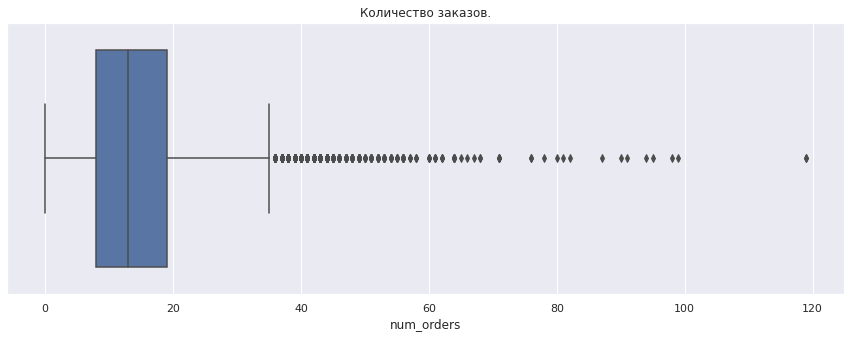

In [7]:
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(data['num_orders']).set_title('Количество заказов.');

### Промежуточный вывод

**Данные в порядке**

## Предобработка данных.

In [8]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [10]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Промежуточный вывод

* **Провели ресемплирование по одному часу**
* **Настроили временной сдвиг, добавили скользящее среднее по 24 часа, выбросили пропуски.**

## Анализ

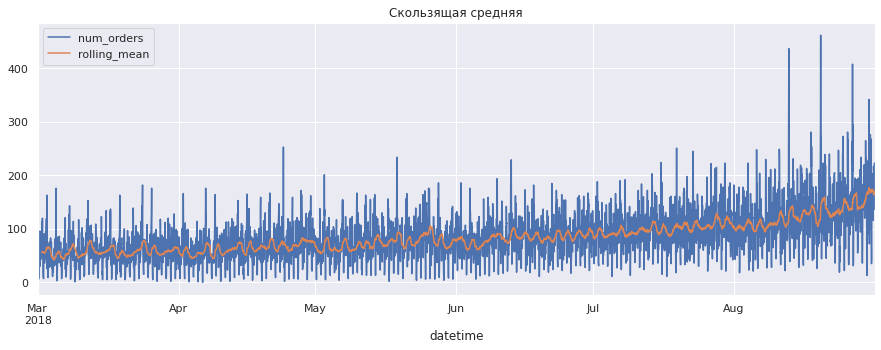

In [11]:
data2 = data.copy()
data2['rolling_mean'] = data.rolling(24).mean()
data2.plot(title='Скользящая средняя');

In [12]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


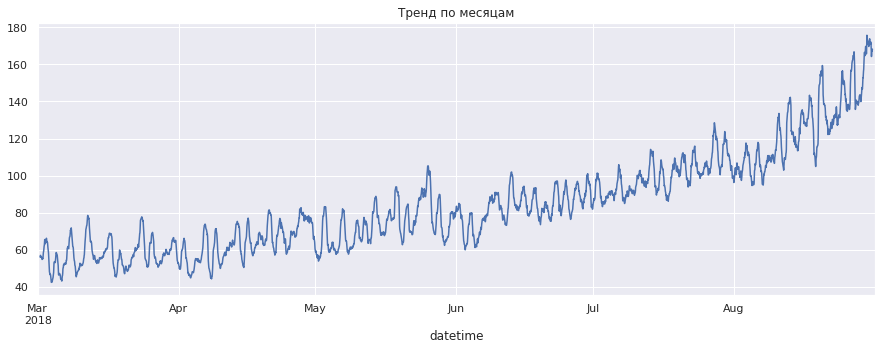

In [13]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(title='Тренд по месяцам');

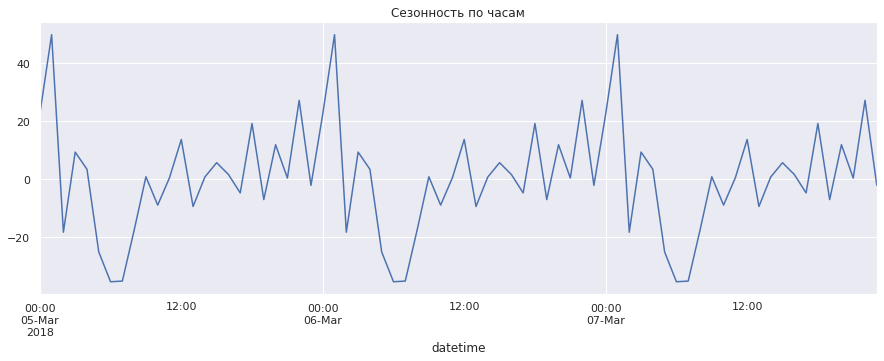

In [14]:
decomposed = seasonal_decompose(data['2018-03-5':'2018-03-7'])
decomposed.seasonal.plot(title='Сезонность по часам');

* **Тренд показывает что заказов с каждым месяцем становится всё больше.**
* **Сезонность по часам показывает как меняется количество заказов в течении суток, от максимального количества заказов вечером до минимального количества утром.**

## Обучение

In [15]:
df = make_features(data, 24, 24).dropna()

train, test = train_test_split(df, shuffle=False, test_size=0.1)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [16]:
tscv = TimeSeriesSplit(n_splits=3)

### LinearRegression

In [17]:
%%time

model = LinearRegression()

model.fit(X_train, y_train)

CPU times: user 19.3 ms, sys: 4.67 ms, total: 24 ms
Wall time: 15.9 ms


LinearRegression()

In [18]:
%%time
scores = cross_val_score(LinearRegression(), X_train, y_train, cv=tscv, scoring = 'neg_root_mean_squared_error')

CPU times: user 148 ms, sys: 193 ms, total: 341 ms
Wall time: 393 ms


In [19]:
print('RMSE модели на кроссвалидации:', (scores*-1).sum()/3)

RMSE модели на кроссвалидации: 27.773206734110147


In [20]:
%%time
predictions = model.predict(X_train)

CPU times: user 4.18 ms, sys: 18 µs, total: 4.2 ms
Wall time: 2.99 ms


**Время обучения модели 8 секунд, RMSE модели 27, время предсказания 12 секунд**

### LightGBM

In [21]:
model_lg = LGBMRegressor()

params = {
    'num_leaves': [7, 15],
    'learning_rate': [0.9],
    'max_depth': [None, 3],
    'n_estimators': [7, 15],
    'random_state': [42],
    'num_iterations': [15],
}

grid = GridSearchCV(model_lg, param_grid = params, cv=tscv, scoring='neg_root_mean_squared_error')

In [22]:
%%time
grid.fit(X_train, y_train)

CPU times: user 3.37 s, sys: 32 ms, total: 3.4 s
Wall time: 3.4 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.9], 'max_depth': [None, 3],
                         'n_estimators': [7, 15], 'num_iterations': [15],
                         'num_leaves': [7, 15], 'random_state': [42]},
             scoring='neg_root_mean_squared_error')

In [23]:
lg_param = grid.best_params_
lg_score = grid.best_score_

print('Лучшие гиперпараметры модели')
print(lg_param)

print('score:')
print('LGBMRegressor RMSE:', lg_score*-1)

Лучшие гиперпараметры модели
{'learning_rate': 0.9, 'max_depth': 3, 'n_estimators': 7, 'num_iterations': 15, 'num_leaves': 7, 'random_state': 42}
score:
LGBMRegressor RMSE: 29.02331326436406


In [24]:
%%time
model_lg = LGBMRegressor(learning_rate = 0.9, 
                         max_depth = 3, 
                         n_estimators = 7, 
                         num_iterations = 15,
                         num_leaves = 15, 
                         random_state= 42)

LGBMR = model_lg.fit(X_train, y_train)

CPU times: user 80.7 ms, sys: 6.01 ms, total: 86.8 ms
Wall time: 74.3 ms


In [25]:
%%time
predictions = LGBMR.predict(X_train)

CPU times: user 66.1 ms, sys: 0 ns, total: 66.1 ms
Wall time: 19.4 ms


**Время поиска лучших гиперпараметров 3 минуты 36 секунд, RMSE модели 30, время обучения 11 секунд, время предсказания 0.15 секунд.**

### CatBoostRegressor

In [26]:
model_cbr = CatBoostRegressor()

params = {
        'iterations':[3],
        'learning_rate':[0.9],
        'depth':[None, 2, 5],
        'random_state': [42],
}

grid_cbr = GridSearchCV(model_cbr, param_grid = params, cv=tscv, scoring='neg_root_mean_squared_error')

In [27]:
%%time
grid_cbr.fit(X_train, y_train);

0:	learn: 21.4944385	total: 52.8ms	remaining: 106ms
1:	learn: 19.3467778	total: 56.8ms	remaining: 28.4ms
2:	learn: 18.5311745	total: 60.7ms	remaining: 0us
0:	learn: 22.8787705	total: 7.2ms	remaining: 14.4ms
1:	learn: 21.0985200	total: 12.2ms	remaining: 6.09ms
2:	learn: 20.2355229	total: 17.8ms	remaining: 0us
0:	learn: 24.6153245	total: 6.61ms	remaining: 13.2ms
1:	learn: 22.8267772	total: 12ms	remaining: 6.02ms
2:	learn: 22.0706647	total: 17.4ms	remaining: 0us
0:	learn: 24.4543951	total: 1.01ms	remaining: 2.02ms
1:	learn: 22.0122505	total: 2.12ms	remaining: 1.06ms
2:	learn: 21.1795528	total: 2.93ms	remaining: 0us
0:	learn: 25.7681846	total: 1.8ms	remaining: 3.6ms
1:	learn: 23.6650654	total: 3.08ms	remaining: 1.54ms
2:	learn: 22.7807212	total: 4.19ms	remaining: 0us
0:	learn: 26.9114607	total: 1.27ms	remaining: 2.55ms
1:	learn: 25.6271950	total: 2.57ms	remaining: 1.28ms
2:	learn: 24.8077432	total: 3.68ms	remaining: 0us
0:	learn: 21.7046249	total: 2.72ms	remaining: 5.44ms
1:	learn: 19.7294

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc7cd53c430>,
             param_grid={'depth': [None, 2, 5], 'iterations': [3],
                         'learning_rate': [0.9], 'random_state': [42]},
             scoring='neg_root_mean_squared_error')

In [28]:
cbr_param = grid_cbr.best_params_
cbr_score = grid_cbr.best_score_

print('Лучшие гиперпараметры модели')
print(cbr_param)

print('score:')
print('CatBoostRegressor RMSE:', cbr_score*-1)

Лучшие гиперпараметры модели
{'depth': 5, 'iterations': 3, 'learning_rate': 0.9, 'random_state': 42}
score:
CatBoostRegressor RMSE: 30.179142968451558


In [29]:
model_cbr = CatBoostRegressor(
    iterations=3,
    learning_rate=0.9,
    depth=2,
    random_state=42
)


In [30]:
%%time
model_cbr.fit(X_train, y_train);

0:	learn: 30.6155615	total: 1.53ms	remaining: 3.05ms
1:	learn: 28.2577584	total: 2.96ms	remaining: 1.48ms
2:	learn: 27.5656787	total: 4.28ms	remaining: 0us
CPU times: user 23.3 ms, sys: 4.56 ms, total: 27.9 ms
Wall time: 525 ms


In [31]:
%%time
predictions = model_cbr.predict(X_train)

CPU times: user 0 ns, sys: 3.17 ms, total: 3.17 ms
Wall time: 2.03 ms


**Время поиска параметров 12 секунд, RMSE 30, время обучения 1 секунда, время предсказания 2 милисекунды.**

### Промежуточный вывод

* **Лучшая модель LinearRegression**
* **Время обучения модели 8 секунд** 
* **RMSE модели 27** 
* **время предсказания 12 секунд**

## Тестирование

In [32]:
%%time

pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = mse**(0.5)
print('RMSE LinearRegression на тестовой выборке: %.2f' % rmse)

RMSE LinearRegression на тестовой выборке: 45.22
CPU times: user 0 ns, sys: 12.9 ms, total: 12.9 ms
Wall time: 3.71 ms


**Результат RMSE на тестовой выборке 45, время предсказания 4 милисекунды.**

### DummyRegressor

In [33]:
dummy = DummyRegressor(strategy='median')

dummy.fit(X_train, y_train)

predict = dummy.predict(X_test)

mse = mean_squared_error(y_test, predict)
rmse = mse**(0.5)
print("RMSE: %.2f" % rmse)

RMSE: 87.21


In [17]:
# Dummy с предыдущим значением.
predict_dummy = X_test.lag_1
f"RMSE Dummy модели составляет {np.sqrt(mean_squared_error(y_test, predict_dummy)):.2f}"

'RMSE Dummy модели составляет 58.88'

**Проверка константной моделью показала что обученая модель справляется лучше.**

## Вывод

### Знакомство с данными

* **Знакомство с данными показало относительный порядок в данных, замечены незначительные выбросы.**

### Предобработка данных

* **Удалили 687 выбросов**
* **Провели ресемплирование по одному часу**
* **Настроили временной сдвиг на 10 строк, добавили скользящее среднее по 15 строкам, выбросили пропуски.**

### Анализ данных

* **Тренд показывает что заказов с каждым месяцем становится всё больше.**
* **Сезонность по часам показывает как меняется количество заказов в течении суток, от максимального количества заказов вечером до минимального количества утром.**

### Обучение моделей.

* **Обучены модели LinearRegression, LightGBM, CatBoostRegressor.**
* **Лучшие показатели у LinearRegression, время обучения модели 8 секунд, RMSE модели 27, время предсказания 12 секунд****

### Тестирование LinearRegression

* **Проведён тест лучшей модели, показатель RMSE 45, время предсказания 4 милисекунды.**
* **Проведена проверка константной моделью DummyRegressor, показатель RMSE модели 87.**